# Module 5: Transfer learning - Exercise

In this session, you will create a **deep convolutional neural network** (DCNN)
to classify **Food100** dataset.

More info on this dataset click [here](http://foodcam.mobi/dataset100.html).

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools, functools
import numpy as np
import pandas as pd
import tensorflow as tf
#from keras import backend as K

import tf_threads
tfconfig = tf_threads.limit(tf, 2)
session = tf.Session(config=tfconfig)
#K.set_session(session)

import h5py
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Reshape, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

# Load dataset

Here's directory structure for this dataset:
~~~
UECFOOD100/
    1/     <<< these folders are category ids
        1.jpg
        2.jpg
        3.jpg
        ...
    2/
    ...
~~~


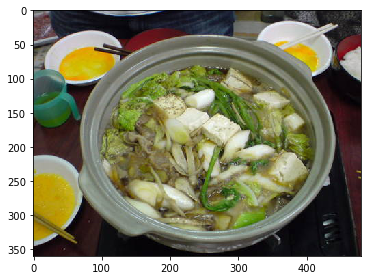

In [10]:
DATASET = lambda fname = '': os.path.join('/dsa/data/all_datasets/transfer_learning/UECFOOD100', fname)
assert os.path.exists(DATASET())

plt.figure(); 
imshow(imread(DATASET('50/9376.jpg')))

# Create a DCNN model based on VGG16

Steps:

1. Specify input shape (150, 150, 3)
2. Create a VGG16 network
2. Lock weights in VGG16
3. Create a classifier very similar to what we did in the Transfer Learning practice
  * the 1st dense layer will have **800** units of neuron with **relu** activation.
  * the 2nd dense layer will have **100** unit of neuron with **softmax** activation.
5. Initialize a **Model** object.

In [11]:
# Add code below this comment  (Question #E5001)
# ----------------------------------
images = Input(shape=(150,150,3))

vgg16 = VGG16(weights = 'imagenet',include_top=False)

for layer in vgg16.layers:
    layer.trainable = False
    
classifier = [
    Flatten(input_shape = vgg16.output_shape[1:]),
    Dense(800, activation = 'relu',name = 'dense_1'),
    Dropout(0.5),
    
    Dense(100, activation='softmax',name='dense_2')
]

y_pred = functools.reduce(lambda f1, f2: f2(f1),[images,vgg16]+classifier)
model = Model(inputs = [images], outputs = [y_pred])

**Compile** model and print a model **summary**.

* **categorical_crossentropy** as loss function
* Adam optimizer with **learning rate = $1 \times 10^{-4}$ **.
* use only `['accuracy']` as metrics

In [12]:
# Add code below this comment  (Question #E5002)
# ----------------------------------
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=.0001),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               6554400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               80100     
Total params: 21,349,188
Trainable params: 6,634,500
Non-trainable params: 14,714,688
________________________________________________________

# Training a DCNN model using transfer learning¶

Create training and validation data generators.

* set batch size = **20**
* set image resolution to **(150,150)** (this is what target_size is referring to)
* set class mode as **'categorical'**

In [13]:
# Add code below this comment  (Question #E5003)
# ----------------------------------
BATCH_SIZE = 20
# Data augmentation
train_datagen = ImageDataGenerator(
   rescale = 1./255,
   shear_range = 0.2,
   zoom_range = 0.2,
   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(
   DATASET('TransferLearning/train'),
   target_size = (150,150),
   batch_size=BATCH_SIZE,
   class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
   DATASET('TransferLearning/validation'),
   target_size=(150,150),
   batch_size=BATCH_SIZE,
   class_mode='categorical'
   )

Found 11443 images belonging to 100 classes.
Found 2912 images belonging to 100 classes.


### Fit this DCNN.

In [ ]:
try:
    model.fit_generator(
        train_generator, steps_per_epoch = 11448 // BATCH_SIZE,
        validation_data=validation_generator, validation_steps = 2913 // BATCH_SIZE,
        epochs=1)
except KeyboardInterrupt:
    """Select from top menu Kernel->Interrupt to quit training and
    leave model parameters (or weights) as they are."""

Epoch 1/1
571/572 [============================>.] - ETA: 7s - loss: 4.2135 - acc: 0.0857 

Save this weights of this model to **"./weights_food100.h5"**.

In [15]:
# Add code below this comment  (Question #E5004)
# ----------------------------------
model.save_weights("./weights_food100.h5")
os.path.exists("./weights_food100.h5")




True

# Evaluation

Evaluate this model. Use **validation_generator** to provide data.

In [16]:
# Add code below this comment  (Question #E5005)
# ----------------------------------

loss, accuracy = model.evaluate_generator(validation_generator,steps=800//BATCH_SIZE)
print('loss:',loss, 'accuracy:', accuracy)


loss: 3.65219137073 accuracy: 0.187500003539


Create a confusion matrix over all 100 categories for the model.

Steps (for each batch):

1. make a prediction for this batch with model.predict() on **X_test**.
2. add true food category ids for this batch to **y_true_sparse**
3. add predicted food category ids for this batch to **y_pred_sparse**

**Note**: validation_generator is an infinite generator, so if you directly traverse it
using a for-loop, it'd be an infinite loop.   
Instead, we use itertools.islice() to slice off the first 100 batches.

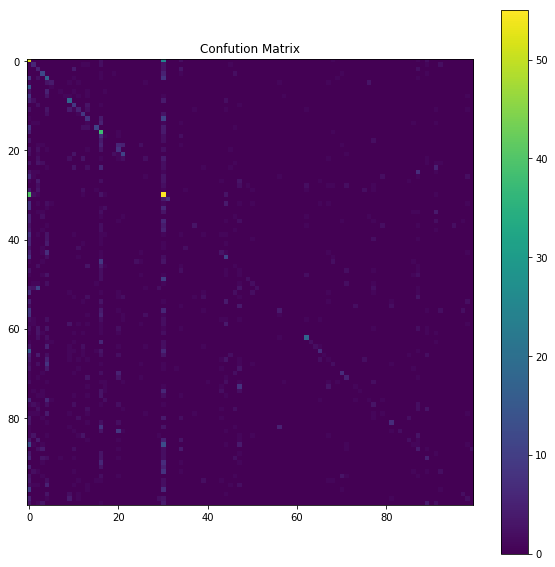

In [17]:
def get_category_id(one_hot_encoding):
    """ This function converts one-hot to sparse encoding,
        which would be the same as category id for this dataset.
        
        Example:
        >>> get_category_id(np.array([[0.1, 0.1, 0.8], [0.9, 0.1, 0.0]]))
        [3, 1]
    """
    return np.argmax(one_hot_encoding, axis=1) + 1

# Sparse labels for creating the confusion matrix
y_true_sparse = [] # true food category id
y_pred_sparse = [] # predicted food category id

for batch in itertools.islice(validation_generator, 100):
    X_test, y_test = batch
    # Add code below this comment to fill in y_true_sparse and y_pred_sparse
    #     (Question #E5006)
    # ----------------------------------
    # 1. make a prediction for this batch
    y_pred = model.predict(X_test)
    
    # 2. add true food category ids for this batch
    
    y_true_sparse.extend(get_category_id(y_test))
    # 3. add predicted food category ids for this batch
    
    y_pred_sparse.extend(get_category_id(y_pred))
    # ----------------------------------

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
plt.imshow(confusion_matrix(y_true_sparse, y_pred_sparse))
plt.title('Confution Matrix')
plt.colorbar()

##### Optional 
You could create another model and try the weights we have trained for you over 50 epochs at  
"`/dsa/data/all_datasets/transfer_learning/UECFOOD100/weights_food100.h5`".

In [ ]:
assert os.path.exists('/dsa/data/all_datasets/transfer_learning/UECFOOD100/weights_food100.h5')

# Do whatever you want below this comment  (Question #E5007)
# ----------------------------------






# Save your notebook!